In [133]:
import pickle
from matplotlib import pyplot as plt
from datetime import datetime
from scipy import interpolate
from tqdm import tqdm
from math import fmod, isclose
import numpy as np
import scipy as sp

from jupyterthemes import jtplot
jtplot.style(theme='gruvboxd', context='talk', fscale=1.4, spines=False, gridlines='--', ticks=True, grid=False, figsize=(6, 4.5))
plt.rcParams['figure.figsize'] = [20, 10]


In [134]:
infile_name = 'braintree_01_riser_prod.csv'
outfile_name = infile_name.split('.')[0]+'.pkl'

parsetime = lambda t: datetime.strptime(t, "%Y-%m-%dT%H:%M:%S.%fZ")

In [135]:
with open(infile_name, 'r') as f:
    dataset = [line.replace("\"", '').replace('\n', '') for line in f.readlines()][1:]
    dataset = [[i.split(',')[0], parsetime(i.split(',')[1]), float(i.split(',')[2])] for i in dataset if i.split(',')[2] != '']
    


In [136]:
sensors = {}

for line in dataset:
    if line[0] not in sensors.keys():
        sensors[line[0]] = []
    sensors[line[0]].append([line[1], line[2]])
    
start_time = min([min([line[0] for line in sensors[key]]) for key in sensors.keys()])

for key in sensors.keys():
    sensors[key] = list(map(lambda l: [(l[0]-start_time).total_seconds(), l[1]], sensors[key]))

end_time = max([max([line[0] for line in sensors[key]]) for key in sensors.keys()])

latest_start_time = max([min([line[0] for line in sensors[key]]) for key in sensors.keys()])
earliest_end_time = min([max([line[0] for line in sensors[key]]) for key in sensors.keys()])



In [147]:
print(start_time)
print(latest_start_time)
print(earliest_end_time)
print(end_time)



2019-04-30 17:35:13.735378
353.155148
8106623.631122
8107390.493431


In [148]:
interp_kind = 'slinear'
sample_ts = 60 # 1 minute

t_start = latest_start_time
t_end = earliest_end_time
t_dur = t_end-t_start
offset = fmod(t_dur, sample_ts)
t_start += offset/2
t_end -= offset/2
t_dur = t_end-t_start
assert(isclose(fmod(t_dur, sample_ts), 0))

num_pts = int(round(t_dur/sample_ts))
assert (isclose(t_start+sample_ts*num_pts, t_end))

sample_pts = np.linspace(t_start, t_end, num_pts+1)
assert (isclose(sample_pts[1]-sample_pts[0], 60))


sensors_interp = sensors.copy()

for key in sensors_interp.keys():
    ts = [line[0] for line in sorted(sensors[key], key=lambda l: l[0])]
    temp = [line[1] for line in sorted(sensors[key], key=lambda l: l[0])]
    interp_fcn = sp.interpolate.interp1d(ts, temp, kind=interp_kind)
    #interp_fcn = sp.interpolate.Akima1DInterpolator(ts, temp)
    interp_temp = np.asarray(interp_fcn(sample_pts))
    sensors_interp[key] = np.vstack([sample_pts, interp_temp]).T


    
keep_days = 75 # 30 days for training, 1 day for testing
end_threshold = t_end - keep_days*3600*24

for key in sensors_interp.keys():
    #print(sensors_interp[key].shape)
    sensors_interp[key] = np.asarray([line for line in sensors_interp[key] if line[0] >= end_threshold])
    #print(sensors_interp[key].shape)

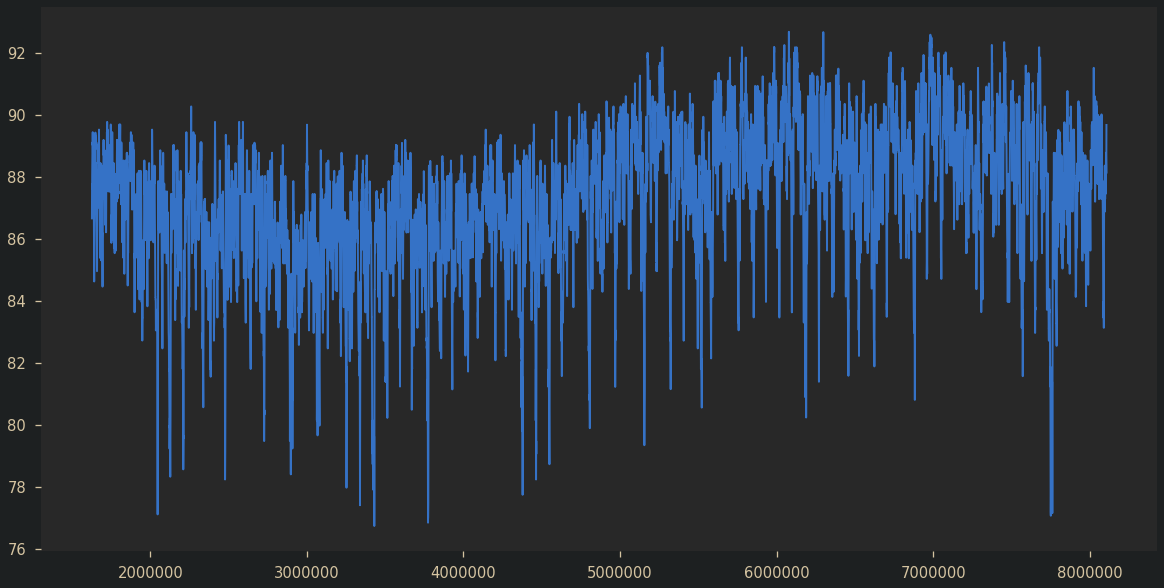

In [149]:
key = '00-0b-57-00-00-2d-e2-cc'
#a1 = np.asarray(sorted(sensors[key], key=lambda l: l[0]))
plt.plot(sensors_interp[key][:,0], sensors_interp[key][:,1])
#plt.plot(a1[:,0], a1[:,1])
plt.show()

In [151]:
sensors_interp['start_time'] = start_time
with open(outfile_name, 'wb') as f:
    pickle.dump(sensors_interp, f)